# Environment simulations using ODEs

Environment dynamics with agents with some understanding of how the environment
works can be simulated as a system of ordinary differential equations. Below is
an example of how to run simulations like that using `gxr.envir` package.

There are three control parameters of interest that may be modified by GuestXR
to achieve desired result - sustainable and relatively equal profit extraction.

* Time horizon in which agents try to predict consequences of their actions,
  i.e. the effects of how much resource they extract from the environment.
  This is controlled by `horizon` parameter, which defines (approximately) the
  length of the time horizon of foresight expressed in terms of the characteristic
  timescale of the environment (the amount of time it needs to regenerate from 5%
  to 95% of its carrying capacity).
  * `horizon` $\in (0, \infty)$ with the default/initial value `horizon = 0.1`
* Time delay of the information about the true state of the environment
  controlled by the `delay` parameter.
  * `delay` $\in (0, \infty)$ with the default/initial value `delay = 1`
* Agents' belief that the other agents will behave similarly to us
  controlled by `alpha` parameter.
  * `alpha` $\in [0, 1]$ with the default/initial value `alpha = 0`
  
* For now the default number of agents is ``4`` as this is the planned number
  of participants in VR experiments.

**NOTE.**

All the above control parameters may be accessed as well as set and/or modified using
standard Python getters and setters.

**NOTE.**

This software runs for `python>=3.11`.

## Initializing game instance

Below is an example of how to initialize a game instance.

In [1]:
from gxr.envir import EnvirGame

game = EnvirGame.from_config()

## Core results

First, let us see some core results to see the main qualitative properties of the model.

### Time horizon

Appropriate time horizon (ability to predict consequences of one's actions)
is sufficient to achieve sustainability of a single agent.

But if the horizon is too short even a single agent may fail.

#### Short time horizon

Here we initialize and run dynamics for a single agent.
With short time horizon the agent fails, which is evident by decreasing
utility after the environment resources are consumed.

**NOTE.**

The argument passed to `dynamics.run()` is the number of "epochs" to run the simulation
for. A single epoch is a time required for the environment to regenerate from a state
of low resources (5% of the carrying capacity) to the state of abundance
(95% of the carrying capacity).

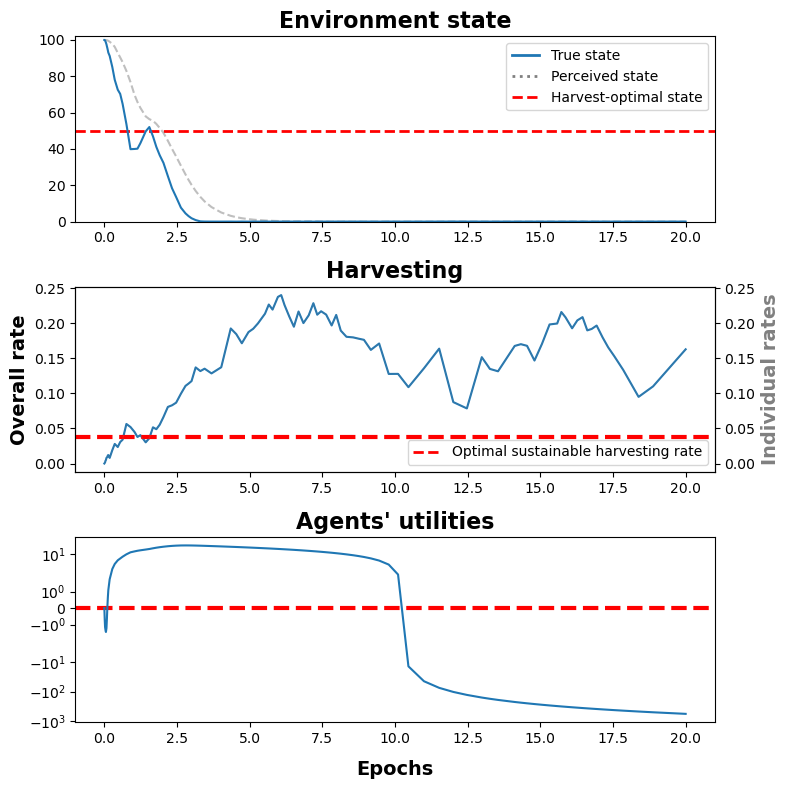

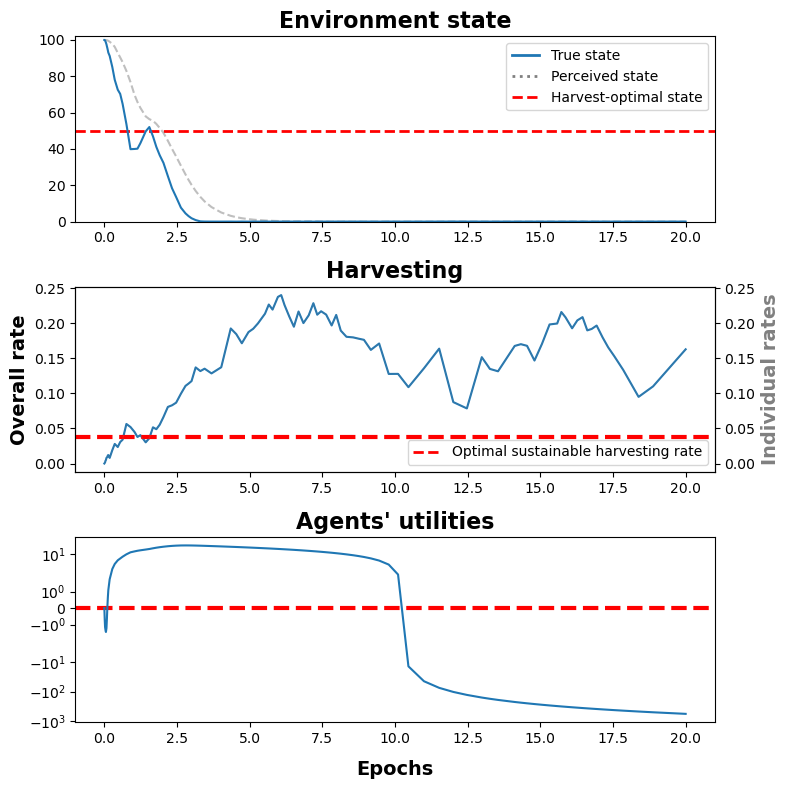

In [2]:
game = EnvirGame.from_config(n_agents=1, horizon=.1)
sol  = game.dynamics.run(20, seed=303)

fig = game.dynamics.plot(sol)
fig

## Long time horizon

With longer time horizon a single agent can succeed.

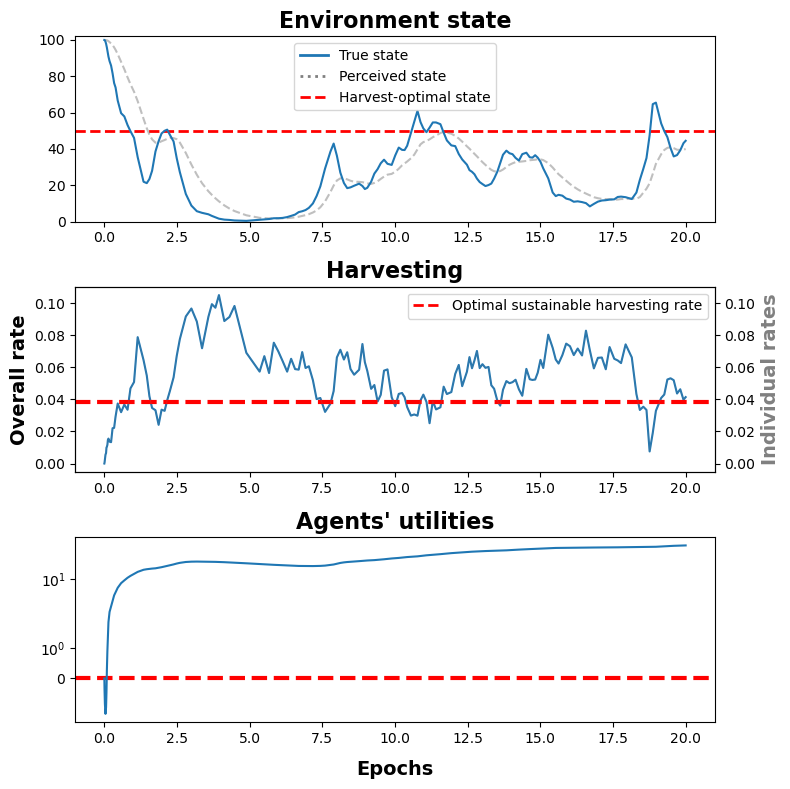

In [3]:
game = EnvirGame.from_config(n_agents=1, horizon=1)
sol  = game.dynamics.run(20, seed=304)

fig = game.dynamics.plot(sol)
fig

And in general the optimal long-term behavior will be approached as `horizon` goes to
infinity.

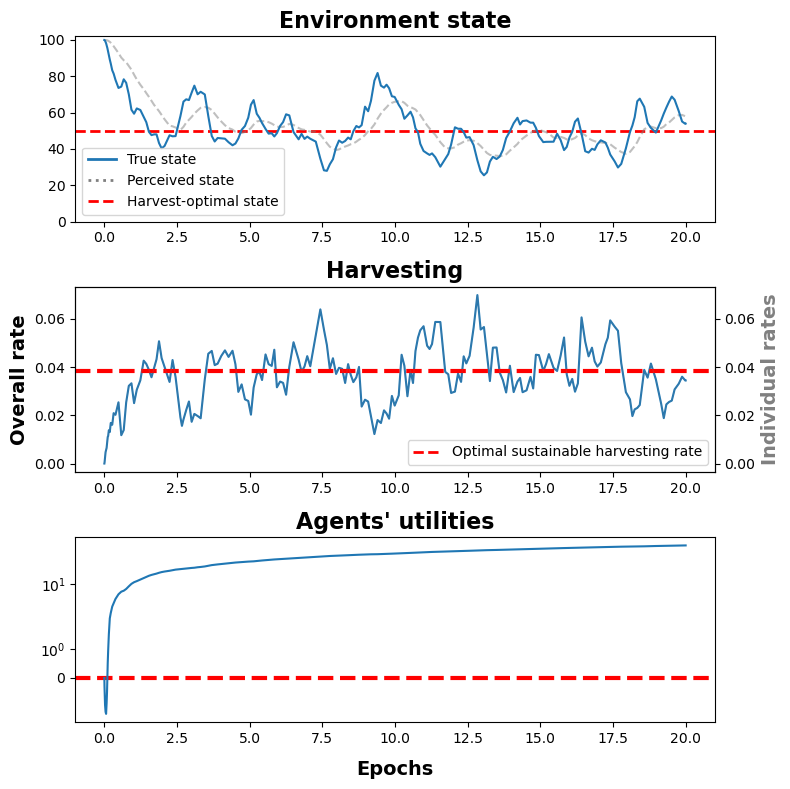

In [4]:
game = EnvirGame.from_config(n_agents=1, horizon=20)
sol  = game.dynamics.run(20, seed=305)

fig = game.dynamics.plot(sol)
fig

## Horizon is not enough in a multi-agent case

But time horizon is not enough by itself in a multi-agent case.
We can see this already in a game with 4 agents.

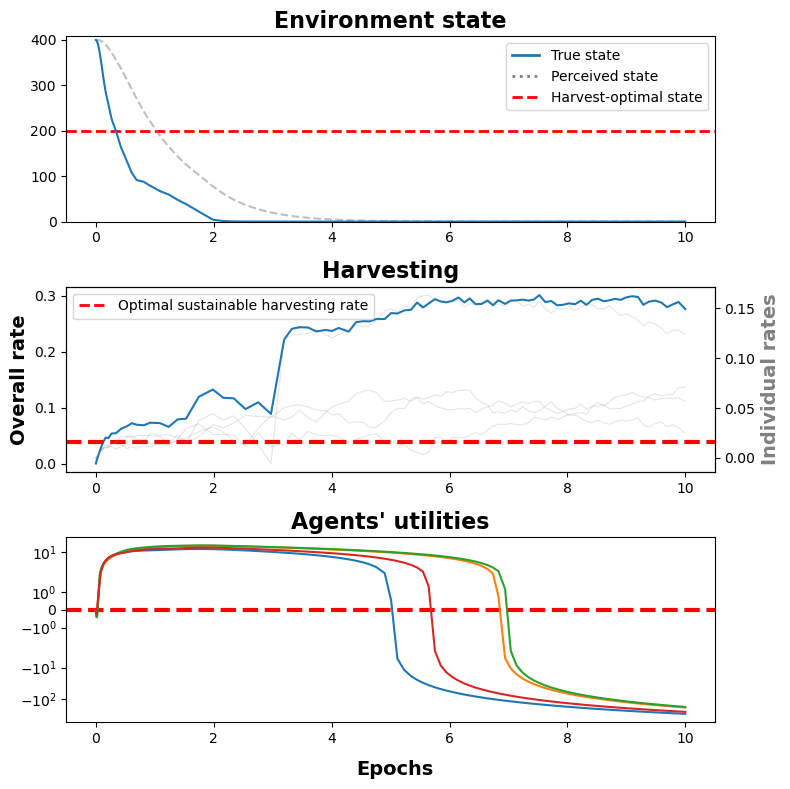

In [5]:
game = EnvirGame.from_config(n_agents=4, horizon=5)
sol  = game.dynamics.run(10, seed=305)

fig = game.dynamics.plot(sol)
fig

## Belief-coordination reduces multi-agent problem to a single-agent problem

Using the `alpha` parameter we can equip the agents with some degree of a belief
that the others will do the same as us, and this effectively reduces the multi-agent
problem to a single-agent problem which can be handled effectively with an appropriate
time horizon.

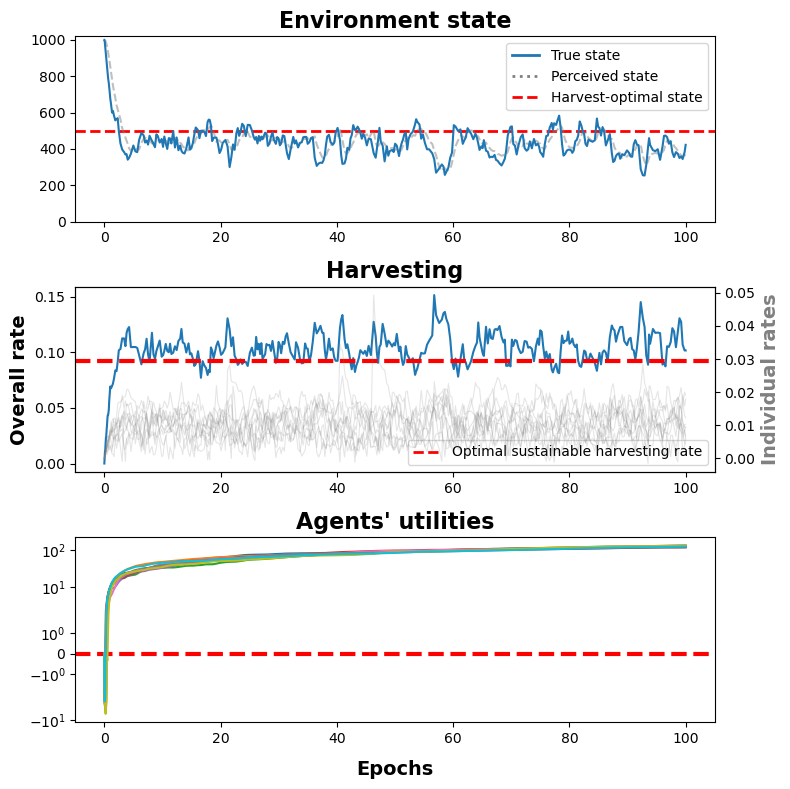

In [108]:
game = EnvirGame.from_config(n_agents=10, horizon=10, alpha=1, noise=0.01, T=50)
sol  = game.dynamics.run(100, seed=None)

fig = game.dynamics.plot(sol)
fig

But note that this will not work if the time horizon is too short.

In [ ]:
game = EnvirGame.from_config(n_agents=4, horizon=.1, alpha=.25)
sol  = game.dynamics.run(10, seed=307)

fig = game.dynamics.plot(sol)
fig

## Effects of time delay

We do not show the effects of time delay in detail. In general, lower time delay just make it
easier to succeed by making predicting consequences easier. 

# Generating training data

Now we turn to the problem of generating data for learning GuestXR policies.
This will be based on the following ideas:

1. Use `EnvirGame` class to run multiple simulations with different control parameters.
   Thus, each run generates one observation with different parameters corresponding
   to features and the change of the reward over time (see below) is what we would
   like to maximize.

2. Use the fact that the dynamics have the form of a Markov chain
   (next step depends only on the current state of the game),
   which allows for generating more specific examples by subsampling
   trajectories, e.g. creating an example using history from some $t$ to some $t'$
   instead of the full history from $0$ to $t_{\text{max}}$.
   Thus, long- and short-term examples can be used by a model to learn long-
   and short-term rewards of particular actions.

## Reward

We will use a reward function that emphasize both high total profits and equal
distribution of profits:

$$
R = \left[\prod_{i=1}^N \max(0, P_i)\right]^{(1/N)}
$$

## Generate training dataset (example)

Here we show an example of how a training dataset may be built
(other approaches are surely possible too).

Of course, the various parameter values below may have to be changed
during an actual usage.

In [ ]:
from itertools import product

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

t_max    = 10
n_agents = 4
n_rep    = 3
n_sub    = 2
Horizon  = np.linspace(.01, 5, 5)
Alpha    = np.linspace(0, 1, 5)
Delay    = np.linspace(.01, 2, 2)
params   = list(product(Horizon, Alpha, Delay))
results  = []
rng      = np.random.default_rng(303)

for horizon, alpha, delay in tqdm(params):
    for _ in range(n_rep):
        game = EnvirGame.from_config(
            n_agents=n_agents,
            horizon=horizon,
            alpha=alpha,
            delay=delay,
            random_state=rng
        )
        sol = game.dynamics.run(t_max)
        rec = game.make_record(sol)
        results.append(rec)

        for _ in range(n_sub):
            sub = sol.sample(random_state=rng)
            rec = game.make_record(sub)
            results.append(rec)

data = pd.DataFrame(results)

And this is how the obtained data looks like. 
The columns have the following definitions:

* `horizon`: value of the `horizon` parameter. 
* `alpha`: value of the `alpha` parameter.
* `delay`: value of the `delay` parameter.
* `dt`: the length of the time interval.
* `E0`: initial state of the environment.
* `P0`: initial profits of individual agents.
* `H0`: initial harvesting rates of individual agents.
* `dR`: change of the reward function over the time interval.
        This is the target we want to maximize.

In [ ]:
data

## Some caveats

* As the core results presented earlier show, the obvious best policy is to increase
  `horizon` as much as possible, increase `alpha` to $1$, and decrease `delay` towards
  $0$ (but it cannot be exactly zero).

* However, starting from some initial values, it is not clear which of the parameters
  should be prioritized. This will also depend on the pace at which GuestXR 
  can manipulate parameters during game.

* In general, it seems that by learning a function from the features to the expected
  change of reward (`dR`), it should be possible to identify desirable perturbations
  of the control of parameters leading to the increase of `dR`.

* Thus, it seems that given the data of the above form, this problem can be framed
  as standard supervised learning.


**NOTE.**
The problem of the mechanics of updating parameters during game is external to
the model presented here and should be handled by the game designers and programmers.